In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('train.csv')
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


### 2. Assess Data : Inspecting Data for Quality and Tidiness Issues
#### 2.1 Quality Issues : Issues with content - missing, duplicate or incorrect data. a.k.a Dirty data 
* 2.1.a Completeness : *"Are there any rows, columns or cells missing values?"*
  * 19 columns has the missing values: ['LotFrontage', 'Alley', 'MasVnrType', 'MasVnrArea', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Electrical', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature']
####   
* 2.1.b Validity : *"Does the data comply to the data schema like duplicate patient id or zip code being < 5 digits or float data type?"*
  * zipcode is float type
  * longitude and lattitude has to be represented in 3 dimentional space (x,y,z). So that digits can be used as the numerical value.
####   
  
* 2.1.c Accuracy : *"Wrong data that is valid. like hieght = 300 inches; it still complies to the standard i.e. inches but data is in accurate."*
  * Census_MedianIncome = 0 may be an outlier
####   
  
* 2.1.d Consistency : *"Both valid and accurate but inconsistent. state = california and CA"*
  * lotsize does not clearly indicate its metric of calculation.
####    


#### 2.2 Tidiness Issues: Issues with structure - untidy or messy data
* 2.2.a Each observation is a row
  * There are 50+ redundant data samples.
######   
* 2.2.b Each variable is a column
  * State is an obsolete column as it has only one value
  * property_type is categorical
  * garage, pool, fireplace, patio are binary
  * time is ordinal (2016.25, 2015.75, 2015.5, 2015.25)
######  
* 2.2.c Each observational unit is a table
  * 'time' variable has introduced redundancy in the dataset
######   

In [3]:
nan_columns = df.columns[df.isna().any()].tolist()
print('NaN columns :', nan_columns, "\n# :", len(nan_columns))

NaN columns : ['LotFrontage', 'Alley', 'MasVnrType', 'MasVnrArea', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Electrical', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature'] 
# : 19


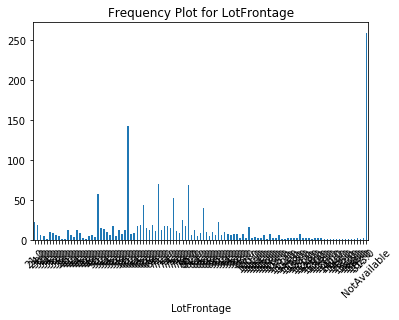

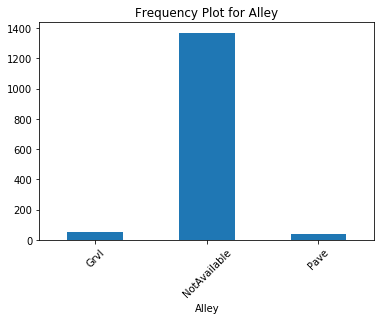

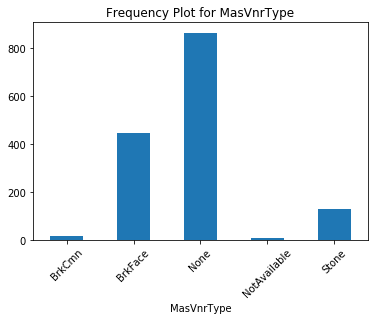

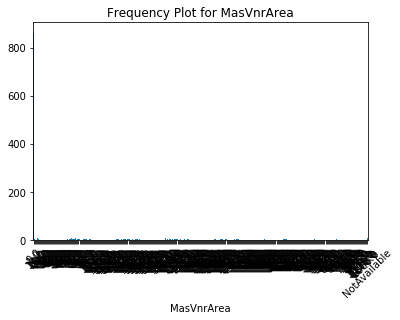

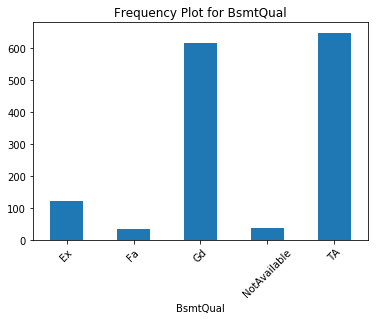

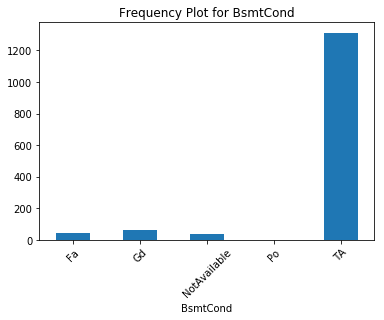

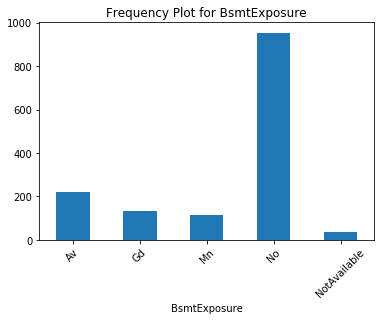

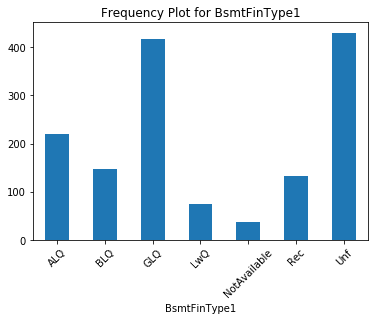

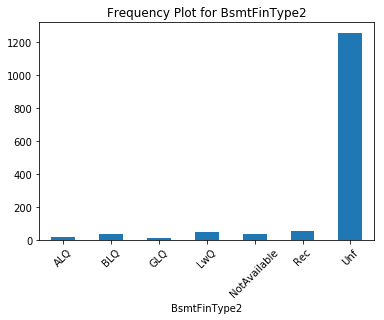

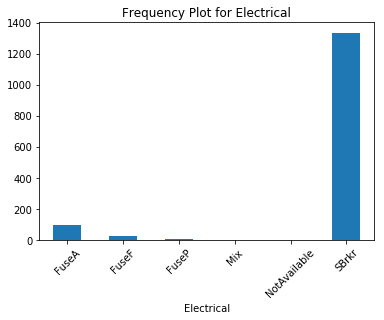

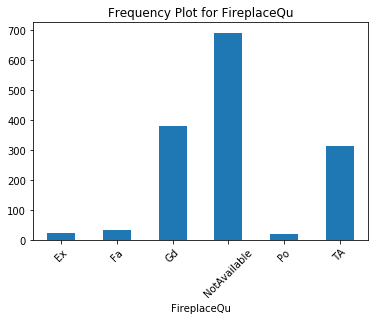

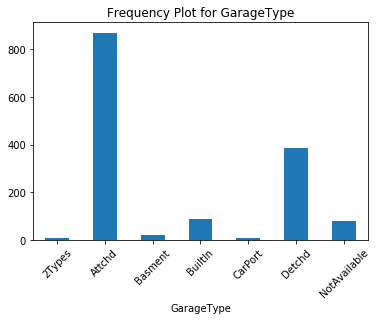

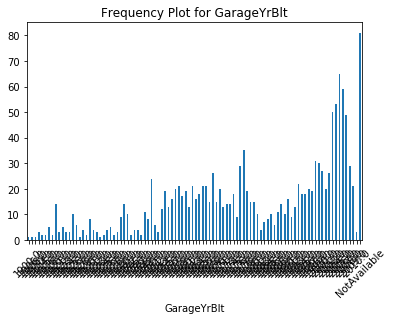

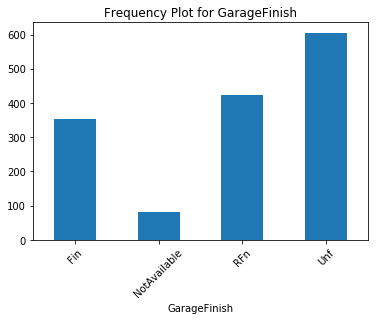

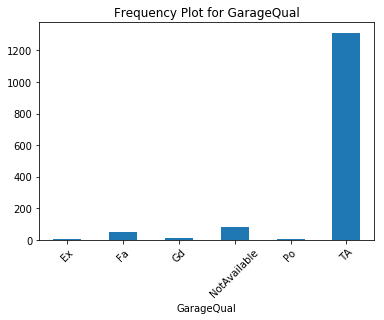

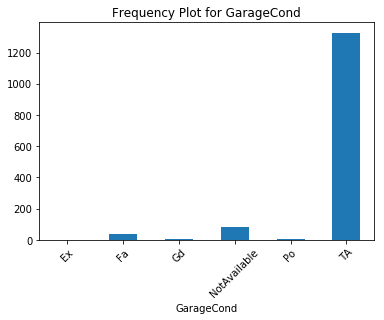

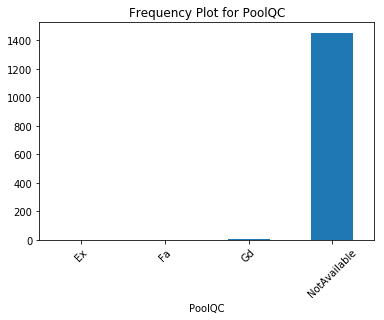

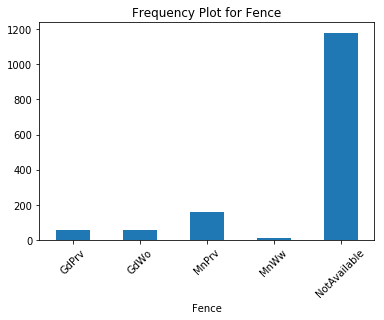

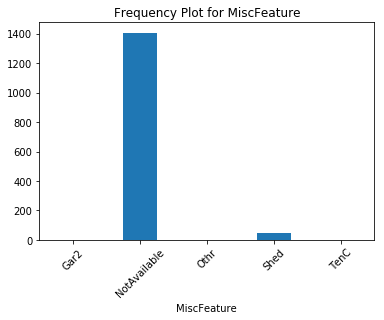

In [4]:
for c in df.fillna('NotAvailable')[nan_columns]:
    df[[c,'SalePrice']].fillna('NotAvailable').\
    groupby(by=c).agg('count').\
    plot.bar(legend=None, title="Frequency Plot for "+c)
    plt.xticks(rotation=45)
    plt.show()

In [5]:
print("LotFrontage : \nmean : ", df.LotFrontage.mean(),  "\nmedian : ",df.LotFrontage.median(), "\nmode : ", df.LotFrontage.mode()) 

LotFrontage : 
mean :  70.04995836802665 
median :  69.0 
mode :  0    60.0
dtype: float64


In [6]:
df['LotFrontage'] =df.LotFrontage.fillna(df.LotFrontage.mode()[0])

In [7]:
'LotFrontage' in df.columns[df.isna().any()].tolist()

False

In [8]:
print("MasVnrArea : \nmean : ", df.MasVnrArea.mean(),  "\nmedian : ",df.MasVnrArea.median(), "\nmode : ", df.MasVnrArea.mode()) 

MasVnrArea : 
mean :  103.68526170798899 
median :  0.0 
mode :  0    0.0
dtype: float64


In [9]:
df[['MasVnrArea','SalePrice']].groupby(['MasVnrArea']).\
    agg('count').reset_index().rename(index=str,columns={'SalePrice':'Count'}).\
    sort_values(by='Count',ascending=False).head()

,MasVnrArea,Count
0,0.0,861
119,180.0,8
63,108.0,8
37,72.0,8
4,16.0,7


In [10]:
df['MasVnrArea']=df.MasVnrArea.fillna(0.0)
'MasVnrArea' in df.columns[df.isna().any()].tolist()

False

In [11]:
print("GarageYrBlt : \nmean : ", df.GarageYrBlt.mean(),  "\nmedian : ",df.GarageYrBlt.median(), "\nmode : ", df.GarageYrBlt.mode()) 

GarageYrBlt : 
mean :  1978.5061638868744 
median :  1980.0 
mode :  0    2005.0
dtype: float64


In [12]:
df[df.GarageYrBlt.isna()].shape

(81, 81)

In [13]:
df[['GarageYrBlt','SalePrice']].groupby(['GarageYrBlt']).\
    agg('count').reset_index().rename(index=str,columns={'SalePrice':'Count'}).\
    sort_values(by='Count',ascending=False).head()

,GarageYrBlt,Count
91,2005.0,65
92,2006.0,59
90,2004.0,53
89,2003.0,50
93,2007.0,49


##### It is too risky to put mode as a imputing value.

In [14]:
df_temp = df.copy()
df_temp['GarageYrBlt'] = df.GarageYrBlt.interpolate('nearest')
df_temp[['GarageYrBlt','SalePrice']].groupby(['GarageYrBlt']).\
    agg('count').reset_index().rename(index=str,columns={'SalePrice':'Count'}).\
    sort_values(by='Count',ascending=False).head()

,GarageYrBlt,Count
91,2005.0,68
92,2006.0,64
90,2004.0,57
89,2003.0,52
93,2007.0,51


In [15]:
df_temp[df.GarageYrBlt.isna()][['GarageYrBlt','YearBuilt']]

,GarageYrBlt,YearBuilt
39,1953.0,1955
48,2006.0,1920
78,1948.0,1968
88,2009.0,1915
89,1950.0,1994
99,1920.0,1959
108,1948.0,1919
125,1979.0,1935
127,1977.0,1930
140,1997.0,1971


##### It cant be true that GarageYrBlt < YearBuilt. Can we see the patter between these two columns when they are present

In [16]:
df[df.GarageYrBlt == df.YearBuilt].shape

(1089, 81)

In [17]:
df[df.GarageYrBlt.isna()].shape

(81, 81)

In [18]:
df.shape

(1460, 81)

* There are 3 options for us :
  * populate garage year built as 0 : Zero is a invalid data, it would not follow the "validity" of the data format. i.e. there is no year with 0. Hence, this option is cancelled.
  * populate garage built year = house built year: This is a misinterpretation of the data as we clearly know that there is no garage and it cannot have yearbuilt value.
  * drop the variable
 
 ##### There are no houses which has garage built year but not type of the finish. This indicates that empty values are only because there is no garage. Should we drop this feature ? because we know that it does not matter for a house when garage was built. It is, however, important to know if the garage is present or not and how big it is if present. Moreover, we do not have the time series of data to support the hypothesis that the sale price got increased post garage is built.

In [38]:
df[df.GarageYrBlt < df.YearBuilt][['GarageYrBlt', 'YearBuilt']]

,GarageYrBlt,YearBuilt
29,1920.0,1927
93,1900.0,1910
324,1961.0,1967
600,2003.0,2005
736,1949.0,1950
1103,1954.0,1959
1376,1925.0,1930
1414,1922.0,1923
1418,1962.0,1963


##### May be in these houses they first used to part thier old car then started their construction. I guess for all practical purpose we may safely assume YearBuilt <= GarageYrBlt.

In [35]:
df[(df.GarageFinish.notna()) & (df.GarageYrBlt.isna()) ][['GarageYrBlt','YearBuilt','GarageType','GarageFinish','GarageCars', 'GarageArea']]

,GarageYrBlt,YearBuilt,GarageType,GarageFinish,GarageCars,GarageArea


In [36]:
df[df.GarageYrBlt.isna()][['GarageYrBlt','YearBuilt','GarageType','GarageFinish','GarageCars', 'GarageArea']]

,GarageYrBlt,YearBuilt,GarageType,GarageFinish,GarageCars,GarageArea
39,NaN,1955,NaN,NaN,0,0
48,NaN,1920,NaN,NaN,0,0
78,NaN,1968,NaN,NaN,0,0
88,NaN,1915,NaN,NaN,0,0
89,NaN,1994,NaN,NaN,0,0
99,NaN,1959,NaN,NaN,0,0
108,NaN,1919,NaN,NaN,0,0
125,NaN,1935,NaN,NaN,0,0
127,NaN,1930,NaN,NaN,0,0
140,NaN,1971,NaN,NaN,0,0


In [40]:
df = df.drop('GarageYrBlt',axis=1)

In [41]:
df = df.fillna('NotAvailable')

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1460 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            1460 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non

In [47]:
for c in list(df):
    print(df[c].describe())
    input("")

count    1460.000000
mean      730.500000
std       421.610009
min         1.000000
25%       365.750000
50%       730.500000
75%      1095.250000
max      1460.000000
Name: Id, dtype: float64

count    1460.000000
mean       56.897260
std        42.300571
min        20.000000
25%        20.000000
50%        50.000000
75%        70.000000
max       190.000000
Name: MSSubClass, dtype: float64

count     1460
unique       5
top         RL
freq      1151
Name: MSZoning, dtype: object

count    1460.000000
mean       68.267123
std        22.356355
min        21.000000
25%        60.000000
50%        63.000000
75%        79.000000
max       313.000000
Name: LotFrontage, dtype: float64

count      1460.000000
mean      10516.828082
std        9981.264932
min        1300.000000
25%        7553.500000
50%        9478.500000
75%       11601.500000
max      215245.000000
Name: LotArea, dtype: float64

count     1460
unique       2
top       Pave
freq      1454
Name: Street, dtype: object

count 


count       1460
unique         7
top       Attchd
freq         870
Name: GarageType, dtype: object

count     1460
unique       4
top        Unf
freq       605
Name: GarageFinish, dtype: object

count    1460.000000
mean        1.767123
std         0.747315
min         0.000000
25%         1.000000
50%         2.000000
75%         2.000000
max         4.000000
Name: GarageCars, dtype: float64

count    1460.000000
mean      472.980137
std       213.804841
min         0.000000
25%       334.500000
50%       480.000000
75%       576.000000
max      1418.000000
Name: GarageArea, dtype: float64

count     1460
unique       6
top         TA
freq      1311
Name: GarageQual, dtype: object

count     1460
unique       6
top         TA
freq      1326
Name: GarageCond, dtype: object

count     1460
unique       3
top          Y
freq      1340
Name: PavedDrive, dtype: object

count    1460.000000
mean       94.244521
std       125.338794
min         0.000000
25%         0.000000
50%         0.0

In [48]:
df[(df.LotArea <11602) & (df.LotArea > 11601)]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice


* Following are Categorical Variables but currently are being considered as integer/float:
  * MSSubClass
  * OverallQual
  * OverallCond
  * FireplaceQu
  * MoSold
  
* Following variables are supposed to be Integer type but Box-Cox or Scaling will anyway type cast them to float:
  * LotFrontage, LotArea, YearBuilt, YearRemodAdd, MasVnrArea, BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, 1stFlrSF, 2ndFlrSF, LowQualFinSF, GrLivArea, BsmtFullBath, BsmtHalfBath, FullBath, HalfBath, BedroomAbvGr, KitchenAbvGr, TotRmsAbvGrd, Fireplaces, GarageCars, GarageArea, WoodDeckSF, OpenPorchSF, EnclosedPorch, 3SsnPorch, ScreenPorch, PoolArea, MiscVal, YrSold, SalePrice
